<div style="Tamplaged                                                                              ">
<b><center><font size="4">Web scraping</font></center></b>
<b><center><font size="3">Scores and Reviews Numbers</font></center></b>
<b><center><font size="2">Automated process to extract info</font></center></b>


</div>

**Notebook Developed by**: [Rene Jerez](https://github.com/renejerez)<br>
**email:**  rene.jerez@libertyseguros.pt<br>

<h1>Scraping Scores and Number of Reviews<span class="tocSkip"></span></h1>
<div class="toc">
  <ul class="toc-item">
    <li><span><a href="#Setup-and-Load-Data" data-toc-modified-id="Setup-and-Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup and Load Data</a></span>
      <div class="toc">
        <ul class="toc-item">
          <li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import libraries</a></span></li>
          <li><span><a href="#Load-bodyshops-from-CSV-file" data-toc-modified-id="Load-bodyshops-from-CSV-file-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load bodyshops from CSV file</a></span></li>
          <li><span><a href="#Find-URLs-for-each-bodyshop" data-toc-modified-id="Find-URLs-for-each-bodyshop-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Find URLs for each bodyshop</a></span></li>
        </ul>
      </div>
    </li>
    <li><span><a href="#WebDriver-Configuration" data-toc-modified-id="WebDriver-Configuration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>WebDriver Configuration</a></span>
      <div class="toc">
        <ul class="toc-item">
          <li><span><a href="#Configure-and-initialize-Chrome-WebDriver" data-toc-modified-id="Configure-and-initialize-Chrome-WebDriver-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Configure and initialize Chrome WebDriver</a></span></li>
        </ul>
      </div>
    </li>
    <li><span><a href="#Web-Scraping-and-Data-Extraction" data-toc-modified-id="Web-Scraping-and-Data-Extraction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Web Scraping and Data Extraction</a></span>
      <div class="toc">
        <ul class="toc-item">
          <li><span><a href="#Open-URLs,-handle-pop-ups" data-toc-modified-id="Open-URLs,-handle-pop-ups-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Open URLs, handle pop-ups</a></span></li>
          <li><span><a href="#Extract-page-content,-scores,-and-'stars'-elements" data-toc-modified-id="Extract-page-content,-scores,-and-'stars'-elements-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Extract page content, scores, and 'stars' elements</a></span></li>
        </ul>
      </div>
    </li>
    <li><span><a href="#Data-Processing-and-Storage" data-toc-modified-id="Data-Processing-and-Storage-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Processing and Storage</a></span>
      <div class="toc">
        <ul class="toc-item">
          <li><span><a href="#Parse-and-count-star-ratings" data-toc-modified-id="Parse-and-count-star-ratings-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Parse and count star ratings</a></span></li>
          <li><span><a href="#Store-results-in-DataFrame" data-toc-modified-id="Store-results-in-DataFrame-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Store results in DataFrame</a></span></li>
        </ul>
      </div>
    </li>
    <li><span><a href="#Final-Data-Integration" data-toc-modified-id="Final-Data-Integration-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Final Data Integration</a></span>
      <div class="toc">
        <ul class="toc-item">
          <li><span><a href="#Merge-extracted-scores-and-reviews-back-into-the-original-DataFrame" data-toc-modified-id="Merge-extracted-scores-and-reviews-back-into-the-original-DataFrame-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Merge extracted scores and reviews back into the original DataFrame</a></span></li>
        </ul>
      </div>
    </li>
  </ul>
</div>


<hr>

# Scraping Scores and Number of Reviews

This script automates the process of scraping review scores and star ratings from a list of URLs stored in a CSV file. Using Selenium WebDriver, it navigates to each URL, handles potential pop-ups, and extracts relevant content using BeautifulSoup. The extracted data includes review scores and star ratings, which are then stored in a DataFrame for further analysis.

## Setup and Load Data

### Import libraries

In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import numpy as np

import time

# Set up Selenium WebDriver
def setup_driver():
    options = Options()
    options.add_argument('--disable-gpu')  # Disable GPU acceleration
    options.add_argument('--no-sandbox')  # Bypass OS security model
    options.add_argument('--disable-dev-shm-usage')  # Overcome limited resource problems
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    return driver

# Open URL and handle pop-ups
def open_url_and_handle_popups(driver, url):
    driver.get(url)
    time.sleep(5)  # Wait for the page to load

    try:
        accept_cookies_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//button[@aria-label='Accept all']"))
        )
        accept_cookies_button.click()
        print("Accepted cookies")
    except Exception as e:
        print(f"No cookies button found or another issue: {e}")

    return driver

# Perform search for "cerveja"
def search_for_cerveja(driver):
    search_box = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "input[class*='pdo-input']"))
    )
    search_box.clear()
    search_box.send_keys("cerveja")
    search_box.send_keys(Keys.ENTER)
    time.sleep(5)  # Wait for search results to load

# Extract product information
def extract_product_info(driver):
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    products = []

    for article in soup.find_all('article', class_='pdo-product-item'):
        products.append({'item': str(article)})

    return products

# Click the "VER SEGUINTES" button to load more products
def click_load_more(driver):
    try:
        load_more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//button[contains(., 'VER SEGUINTES')]"))
        )
        load_more_button.click()
        time.sleep(5)  # Wait for the new products to load
        return True
    except:
        return False

# Main execution
if __name__ == "__main__":
    driver = setup_driver()
    driver = open_url_and_handle_popups(driver, "https://mercadao.pt/store/pingo-doce")
    search_for_cerveja(driver)

    all_products = []
    
    while True:
        products = extract_product_info(driver)
        all_products.extend(products)
        if not click_load_more(driver):
            break
    
    driver.quit()

    df = pd.DataFrame(all_products)


No cookies button found or another issue: Message: 
Stacktrace:
	GetHandleVerifier [0x00C90F03+27667]
	(No symbol) [0x00C26C04]
	(No symbol) [0x00B21AFF]
	(No symbol) [0x00B62BFE]
	(No symbol) [0x00B62CDB]
	(No symbol) [0x00B9EC22]
	(No symbol) [0x00B83974]
	(No symbol) [0x00B9CAC7]
	(No symbol) [0x00B836C6]
	(No symbol) [0x00B574D1]
	(No symbol) [0x00B5804D]
	GetHandleVerifier [0x00F43D83+2857619]
	GetHandleVerifier [0x00F97EED+3202045]
	GetHandleVerifier [0x00D14704+566292]
	GetHandleVerifier [0x00D1B8FC+595468]
	(No symbol) [0x00C2F9F4]
	(No symbol) [0x00C2C708]
	(No symbol) [0x00C2C8A7]
	(No symbol) [0x00C1E79E]
	BaseThreadInitThunk [0x7714FCC9+25]
	RtlGetAppContainerNamedObjectPath [0x772C80CE+286]
	RtlGetAppContainerNamedObjectPath [0x772C809E+238]



In [2]:
# Product name from product list extract
def extract_product_name(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    product_name_tag = soup.find('h3', class_='pdo-heading-s detail-title')
    return product_name_tag.get_text(strip=True) if product_name_tag else 'N/A'
df['product_name'] = df['item'].apply(extract_product_name)

In [3]:
# Extract product size
def extract_product_size(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    product_size_tag = soup.find('pdo-product-price-per-unit', class_='pdo-block')
    if product_size_tag:
        size_text = product_size_tag.find('span').get_text(strip=True)
        size_parts = size_text.split('|')[0].strip()  # Extract the part before the '|'
        return size_parts  # Return the size part (e.g., '50 CL')
    return 'N/A'

df['product_size'] = df['item'].apply(extract_product_size)

In [4]:
# Extract product price from HTML content stored in 'item' column
def extract_product_price(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    product_price_tag = soup.find('pdo-product-price-tag', class_='pdo-block')
    if product_price_tag:
        price_text = product_price_tag.find('span', class_='pdo-inline-block pdo-middle ng-star-inserted').get_text(strip=True)
        return price_text.split('€')[0].strip()  # Extract the price part (e.g., '1,99')
    return 'N/A'
df['product_price'] = df['item'].apply(extract_product_price)

In [5]:
# Extract product promotion from HTML content stored in 'item' column
def extract_product_promotion(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    product_promotion_tag = soup.find('h4', class_='pdo-text-sm promotion-label ng-star-inserted')
    if product_promotion_tag:
        spans = product_promotion_tag.find_all('span', class_='label-bold')
        if spans:
            promotion_text = ''.join(span.get_text(strip=True) for span in spans)
            promotion_text = promotion_text.replace("+ de", "").strip()  # Remove "+ de" and strip any leading/trailing spaces
            return promotion_text  # Return the promotion part (e.g., '30%')
    return 'N/A'

df['product_promotion_percentage'] = df['item'].apply(extract_product_promotion)


In [6]:
# Convert product_price to numeric type
df['product_price'] = df['product_price'].str.replace(',', '.').astype(float)


In [7]:
# Convert product_promotion to percentage, replacing 'N/A' with 0
df['product_promotion_percentage'] = df['product_promotion_percentage'].replace('N/A', '0%')  # Replace 'N/A' with '0%'
df['product_promotion_percentage'] = df['product_promotion_percentage'].str.replace('%', '').astype(float) / 100  # Convert to float and then to percentage

In [9]:
!pip install matplotlib

  Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl (189 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)


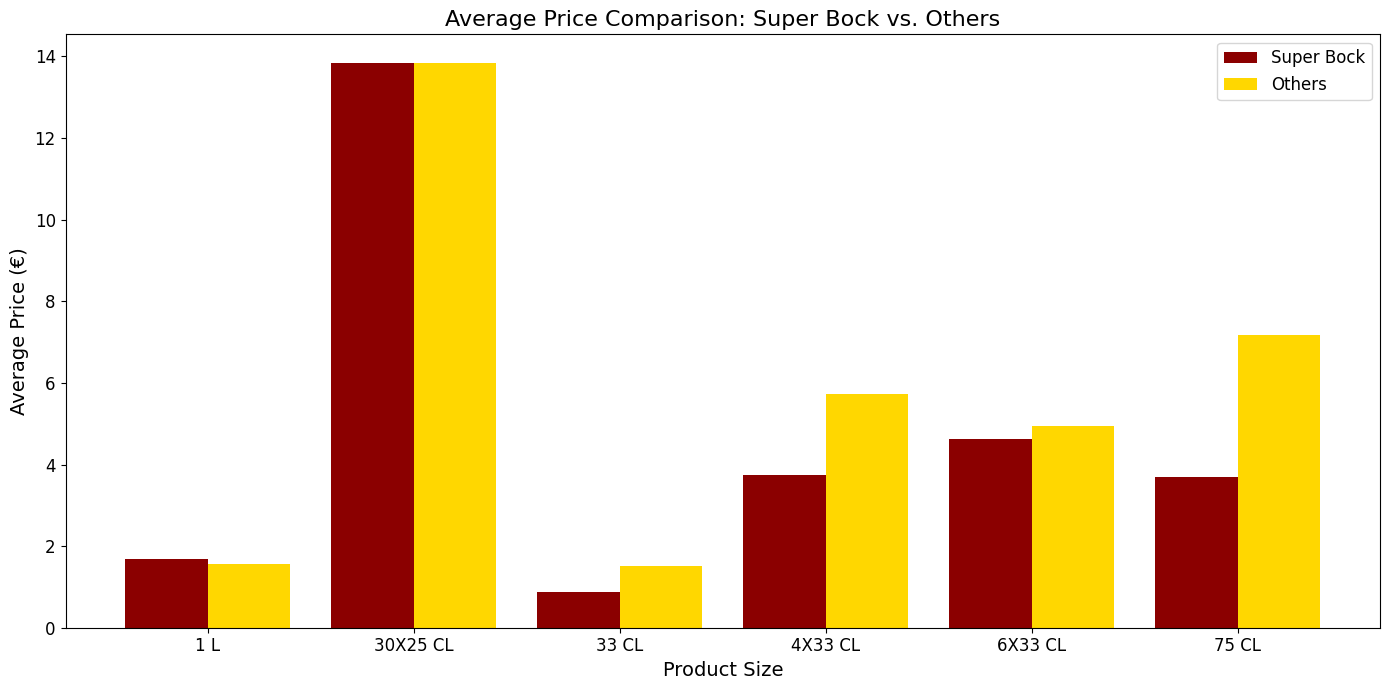

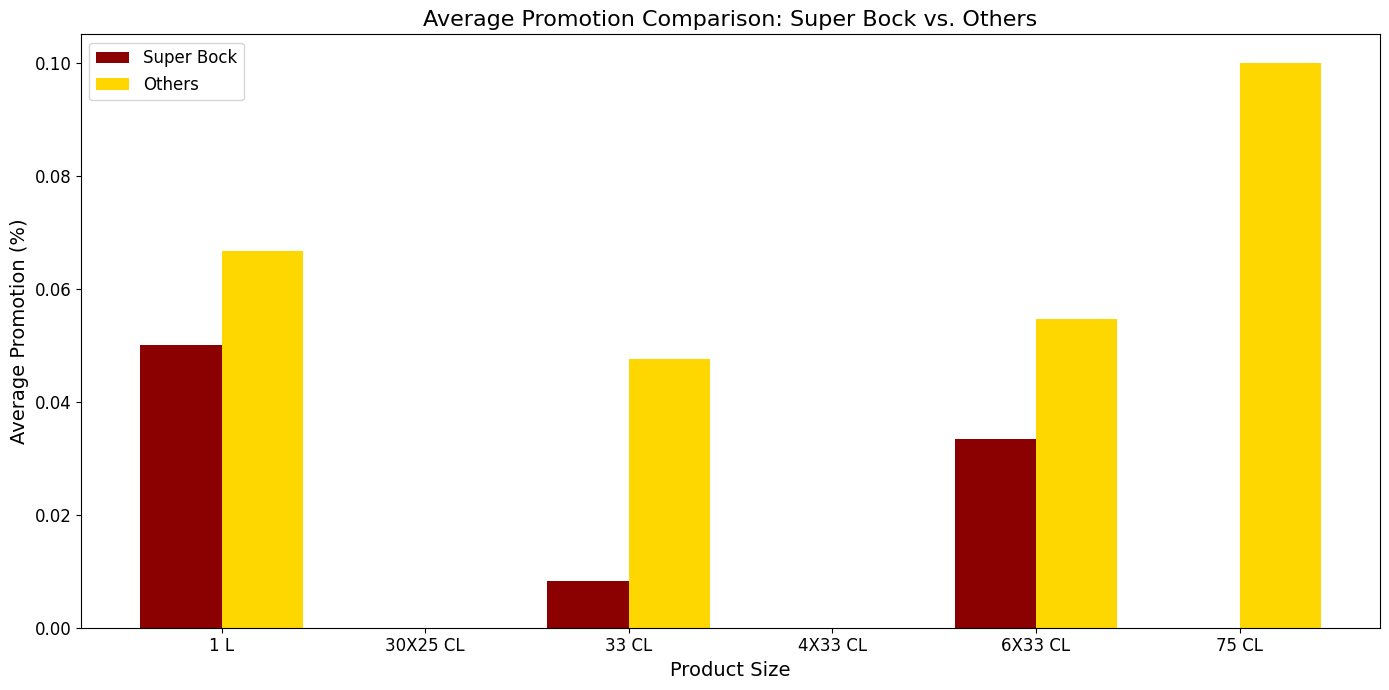

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify products that belong to "Super Bock"
df['is_super_bock'] = df['product_name'].str.contains('Super Bock', case=False, na=False)

# Separate the data into two groups: Super Bock and Others
super_bock_df = df[df['is_super_bock']]
others_df = df[~df['is_super_bock']]

# Group by product size and calculate summary statistics for Super Bock
super_bock_stats = super_bock_df.groupby('product_size').agg(
    avg_price=('product_price', 'mean'),
    avg_promotion=('product_promotion_percentage', 'mean')
).reset_index()

# Group by product size and calculate summary statistics for Others
others_stats = others_df.groupby('product_size').agg(
    avg_price=('product_price', 'mean'),
    avg_promotion=('product_promotion_percentage', 'mean')
).reset_index()

# Merge the statistics for comparison
comparison_df = super_bock_stats.merge(others_stats, on='product_size', suffixes=('_super_bock', '_others'))

# Plot Average Price Comparison: Super Bock vs. Others with stronger colors and parallel columns
plt.figure(figsize=(14, 7))
bar_width = 0.4
index = range(len(comparison_df))

bar1 = plt.bar(index, comparison_df['avg_price_super_bock'], bar_width, color='darkred', label='Super Bock')
bar2 = plt.bar([i + bar_width for i in index], comparison_df['avg_price_others'], bar_width, color='gold', label='Others')

plt.title('Average Price Comparison: Super Bock vs. Others', fontsize=16)
plt.xlabel('Product Size', fontsize=14)
plt.ylabel('Average Price (€)', fontsize=14)
plt.xticks([i + bar_width / 2 for i in index], comparison_df['product_size'], rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot Average Promotion Comparison: Super Bock vs. Others with stronger colors and parallel columns
plt.figure(figsize=(14, 7))
bar1 = plt.bar(index, comparison_df['avg_promotion_super_bock'], bar_width, color='darkred', label='Super Bock')
bar2 = plt.bar([i + bar_width for i in index], comparison_df['avg_promotion_others'], bar_width, color='gold', label='Others')

plt.title('Average Promotion Comparison: Super Bock vs. Others', fontsize=16)
plt.xlabel('Product Size', fontsize=14)
plt.ylabel('Average Promotion (%)', fontsize=14)
plt.xticks([i + bar_width / 2 for i in index], comparison_df['product_size'], rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
